This is analysis is composed of three parts.
- Data Preparation Sports Reference, Basketball Reference (pre-downloaded in excel) and Draft Express, NBA.com
- Model Training
- 2018 Projections

# 1. Data Preparation

## 1.1 College Performance and Early Success

https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059

In [1]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np

In [2]:
# Sports Reference
college = pd.DataFrame()

for offset in range(0, 20000, 100):
    url = 'https://www.sports-reference.com/cbb/play-index/psl_finder.cgi?request=1&match=combined&year_min=2008&year_max=2019&class_is_fr=Y&class_is_so=Y&class_is_jr=Y&class_is_sr=Y&pos_is_g=Y&pos_is_gf=Y&pos_is_f=Y&pos_is_fg=Y&pos_is_fc=Y&pos_is_c=Y&pos_is_cf=Y&games_type=A&order_by=pts&offset=' + str(offset)
    # Create a handle, page, to handle the contents of the website
    page = requests.get(url)
    # Store the contents of the website under doc
    doc = lh.fromstring(page.content)
    # Parse data that are stored between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')

    # tr_elements = tr_elements[1:]

    # Check the length of the first 12 rows
    # [len(T) for T in tr_elements[:12]]

    # Create empty list
    col = []
    i = 0
    # For each row, store each first element (header) and an empty list
    for t in tr_elements[1]:
        i += 1
        name = t.text_content()
        # print('%d:"%s"'%(i, name))
        col.append((name, []))

    # Since out first row is the header, data is stored on the second row onwards
    for j in range(2, len(tr_elements)):
        # T is our j'th row
        T = tr_elements[j]

        # If row is not of size 25, the //tr data is not from our table 
        if len(T) != 25:
            j += 1
            T = tr_elements[j]

        if len(T) != 25:
            break

        # i is the index of our column
        i = 0

        # Iterate through each element of the row
        for t in T.iterchildren():
            data = t.text_content() 
            # Check if row is empty

            #Append the data to the empty list of the i'th column
            col[i][1].append(data)
            #Increment i for the next column
            i += 1

    Dict = {title:column for (title,column) in col}
    df = pd.DataFrame(Dict)
    df = df[df.Rk != 'Rk']
    college = college.append(df)

college.to_csv('college.csv', index = False) # store the data to avoid the need to do web scraping again

In [3]:
college = pd.read_csv('college.csv')

In [4]:
early_success = pd.read_csv('early success.csv')
early_success.head()

,Player,From,To,Tm,Lg,WS,G,GS,MP,PER,...,ORtg,DRtg,OWS,DWS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Kawhi Leonard,2012,2014,SAS,NBA,19.4,188,161,5267,17.6,...,116.0,99,9.8,9.6,0.177,1.9,2.8,4.7,8.9,2011
1,Kenneth Faried,2012,2014,DEN,NBA,18.9,206,196,5463,19.7,...,116.0,104,11.7,7.2,0.166,0.9,1.2,2.0,5.6,2011
2,Jonas Valanciunas,2013,2015,TOR,NBA,18.9,223,218,5860,17.6,...,116.0,105,11.8,7.1,0.155,-0.9,0.1,-0.8,1.7,2011
3,Chandler Parsons,2012,2014,HOU,NBA,18.0,213,207,7345,15.0,...,112.0,107,11.5,6.4,0.117,1.8,0.6,2.4,8.2,2011
4,Isaiah Thomas,2012,2014,SAC,NBA,17.1,216,153,6275,18.7,...,115.0,113,15.8,1.2,0.130,4.0,-2.8,1.2,5.1,2011


In [5]:
early_success.Year.describe() # 2011 - 2018

count     417.000000
mean     2014.465228
std         2.320346
min      2011.000000
25%      2012.000000
50%      2014.000000
75%      2017.000000
max      2018.000000
Name: Year, dtype: float64

## 1.2 Draft History

https://medium.com/analytics-vidhya/web-scraping-wiki-tables-using-beautifulsoup-and-python-6b9ea26d8722
https://stackoverflow.com/questions/46242664/python-web-scraping-html-table-and-printing-to-csv

In [6]:
# Draft Express
drafts = pd.DataFrame()

for year in range(2011, 2019, 1): 

    url = 'http://www.draftexpress.com/nba-mock-history/' + str(year) + '/all/all/'
    # Create a handle, page, to handle the contents of the website
    website_url = requests.get(url).text
    # Store the contents of the website under doc

    from bs4 import BeautifulSoup
    soup = BeautifulSoup(website_url, 'lxml')
    # print(soup.prettify())

    table = soup.find('table')

    list_of_rows = []
    for row in table.findAll('tr'):
        list_of_cells = []
        for cell in row.findAll(["th","td"]):
            text = cell.text
            list_of_cells.append(text)
        list_of_rows.append(list_of_cells)

    df = pd.DataFrame(list_of_rows[2:])

    df.columns = ['Year', 'Rank', 'Team', 'Player', 'Country', 'Position', 'Age', 'PTS', 'REB', 'AST', 'PER', 'Team', 'League', 'NBA EWA']

    df.replace('\n', '', regex = True, inplace = True)
    df.replace('\t', '', regex = True, inplace = True)
    df.replace('-', '', regex = True, inplace = True)
    # df.columns = df.columns.str.replace(' +$', '')
    df.drop('Team', axis = 1, inplace = True)

    links = soup.findAll('div', {'class':'flag-icon'})
    countries = []
    for link in links:
        countries.append(link.get('title'))

    teams = ['Hawks', 'Celtics', 'Nets', 'Hornets', 
            'Bulls', 'Cavaliers', 'Mavericks', 'Nuggets', 
            'Pistons', 'Warriors', 'Rockets', 'Pacers',
            'Clippers', 'Lakers', 'Grizzlies', 'Heat',
            'Bucks', 'Timberwolves', 'Pelicans', 'Knicks',
            'Thunder', 'Magic', '76ers', 'Suns', 
            'Trailblazers', 'Kings', 'Spurs', 'Raptors',
            'Jazz', 'Wizards']

    links = soup.findAll('img', {'title': teams})
    teams = []
    for link in links:
        teams.append(link.get('title'))

    df['Country'] = countries
    df['Team'] = teams
    drafts = drafts.append(df)

drafts['Player'] = drafts['Player'].str.replace(' +$', '')

drafts['Player'] = drafts['Player'].replace('JaJuan Johnson (Purdue)', 'JaJuan Johnson')
drafts['Player'] = drafts['Player'].replace('Justin Jackson (Canada)', 'Justin Jackson')

drafts['Player'] = drafts['Player'].replace('')
drafts.to_csv('drafts.csv', index = False)

In [7]:
drafts = pd.read_csv('drafts.csv')

## 1.3 Physical Data

http://kevincsong.com/Scraping-stats.nba.com-with-python/

In [8]:
%matplotlib inline
from selenium import webdriver
from pandas import *
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import *

In [23]:
# NBA.com
# This one requires chrome driver to collect tables from it
path_to_chromedriver = 'C:/Users/jczsh/Anaconda3/pkgs/chromedriver-2.35-0/Library/bin/chromedriver' # Path to access a chrome driver
browser = webdriver.Chrome(executable_path = path_to_chromedriver)

url = 'https://stats.nba.com/draft/combine-anthro'
browser.get(url)

In [29]:
# try many times this will work
phy_stats = pd.DataFrame()

for year in range(2011, 2019):
    xpath = '/html/body/main/div[2]/div/div[2]/div/div/div[1]/div[1]/div/div/label/select/option[' + str(2019 - year) + ']'
    
    browser.find_element_by_xpath(xpath).click()
    table = browser.find_element_by_class_name('nba-stat-table')

    PLAYER = []
    TABLE = []

    for line_id, lines in enumerate(table.text.split('\n')):
        if line_id >= 1:
            TABLE.append( [i for i in lines.split(' ')] )

    n_rows = int((len(TABLE) - 1)/2)
    if year == 2013:
        TABLE = TABLE[:33] + TABLE[34:n_rows]
        n_rows = n_rows - 1
        
    if year == 2017:
        TABLE = TABLE[:25] + TABLE[36:n_rows]
        n_rows = n_rows - 1
    physical = pandas.DataFrame({
                           'Player': [i[0] + ' ' + i[1] for i in TABLE[:n_rows]],
                           #'POS': [i[2] for i in TABLE[:n_rows]],
                           'BODY FAT': [i[3] for i in TABLE[:n_rows]], 
                           #'HAND_LENGTH': [i[4] for i in TABLE[:n_rows]],
                           #'HAND_WIDTH': [i[5] for i in TABLE[:n_rows]],
                           'HEIGHT_NO_SHOES': [i[6] + ' ' + i[7] for i in TABLE[:n_rows]],
                           #'HEIGHT_WITH_SHOES': [i[8] + ' ' + i[9] for i in TABLE[:n_rows]],
                           'STANDING_REACH': [i[10] + ' ' + i[11] for i in TABLE[:n_rows]],
                           'WEIGHT': [i[12] for i in TABLE[:n_rows]],
                           'WINGSPAN': [i[13] + ' ' + i[14] for i in TABLE[:n_rows]],
                           }
                         )
    physical['Year'] = year
    phy_stats = phy_stats.append(physical)

In [30]:
phy_stats.head()

,Player,BODY FAT,HEIGHT_NO_SHOES,STANDING_REACH,WEIGHT,WINGSPAN,Year
0,Keith Benson,6.10%,6' 10'',9' 1.5'',217.0,7' 3.75'',2011
1,Marshon Brooks,5.20%,6' 4.25'',8' 5'',194.6,7' 1'',2011
2,Alec Burks,5.10%,6' 5'',8' 7.5'',192.6,6' 10'',2011
3,Jimmy Butler,5.40%,6' 6'',8' 5.5'',222.2,6' 7.5'',2011
4,Norris Cole,4.70%,6' 0.25'',7' 11.5'',174.4,6' 2.25'',2011


In [31]:
phy_stats['HEIGHT_NO_SHOES'] = phy_stats['HEIGHT_NO_SHOES'].apply(lambda x: float(x.replace("'", "").split(" ")[0])*12 + float(x.replace("'", "").split(" ")[1]))
phy_stats['WINGSPAN'] = phy_stats['WINGSPAN'].apply(lambda x: float(x.replace("'", "").split(" ")[0])*12 + float(x.replace("'", "").split(" ")[1]))

THere are some players with wrong value fetched for each attribute because they have two spaces in their name. This is a problem but there are not many players are like this and when merging with other tables, their data will be filtered out. THerefore in the analysis I left out these players for now. More accurate results should be generated if parsing the data more appropriately.

In [32]:
phy_stats.to_csv('phy_stats.csv', index = False)

In [33]:
phy_stats = pd.read_csv('phy_stats.csv')

# 2 Modeling

### Use 2011-2017 predict 2018

- Feature Selection

- Methods:
**Linear Regression,**
**KNN,**
**Decision trees (Random Forest)**

## 2.1 Feature Selection

https://www.cmusportsanalytics.com/2017-nba-draft-forecast/

- Using correlation table to get rid of redundant features.
- This is a predictive model (no explanatory).
- Predict for 2018
- Ranking overestimate and underestimate

College Stats

In [34]:
# change to 'per game'
for col in ['FG', 'FGA',
       '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS']:
    college[col] = college[col]/college['G']

In [35]:
col_stats = college[['Player', 'G', 'FG', 'FGA',
       '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS']]

Early Success

In [36]:
early_success.columns # 'PER' player efficiency rating

Index(['Player', 'From', 'To', 'Tm', 'Lg', 'WS', 'G', 'GS', 'MP', 'PER',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'ORtg', 'DRtg', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'Year'],
      dtype='object')

In [37]:
pred_vorp = early_success[['Year', 'Player', 'VORP']]

Drafts

In [39]:
drafts['Year'] = drafts['Year'].astype('int')

drft_players = pd.merge(drafts[['Year', 'Player', 'Country', 'Position', 'Team']], pred_vorp, on = ['Year', 'Player'])

drft_players # 394

,Year,Player,Country,Position,Team,VORP
0,2011,Kyrie Irving,USA,PG,Cavaliers,8.1
1,2011,Derrick Williams,USA,PF,Timberwolves,-1.5
2,2011,Enes Kanter,Turkey,C,Jazz,-1.6
3,2011,Tristan Thompson,Canada,PF,Cavaliers,0.2
4,2011,Jonas Valanciunas,Lithuania,C,Raptors,1.7
5,2011,Jan Vesely,Czech Republic,PF,Wizards,0.9
6,2011,Bismack Biyombo,Congo,PF/C,Hornets,-1.5
7,2011,Brandon Knight,USA,PG,Pistons,0.6
8,2011,Kemba Walker,USA,PG,Hornets,5.3
9,2011,Jimmer Fredette,USA,PG,Kings,-1.1


In [40]:
# Marvin Bagley III
# Jaren Jackson Jr.
col_stats.loc[col_stats.Player == 'Marvin Bagley III', 'Player'] = 'Marvin Bagley'
col_stats.loc[col_stats.Player == 'Jaren Jackson Jr.', 'Player'] = 'Jaren Jackson'

C:\Users\jczsh\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
col_vorp = pd.merge(pred_vorp, col_stats, on = ['Player'])

In [42]:
col_vorp.drop('PTS', axis = 1, inplace = True)
col_vorp.drop(['FG', 'FGA'], axis = 1, inplace = True)
col_vorp.drop('TRB', axis = 1, inplace = True)

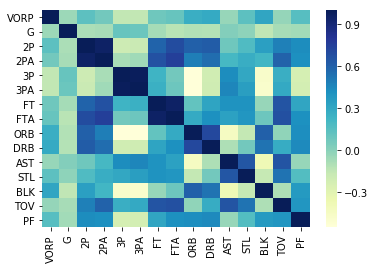

In [43]:
import seaborn as sns
corr = col_vorp.iloc[:, 2:].corr()
sns.heatmap(corr, 
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            cmap = "YlGnBu")

In [44]:
phy_stats[['Year', 'Player', 'HEIGHT_NO_SHOES', 'WEIGHT', 'WINGSPAN']]

,Year,Player,HEIGHT_NO_SHOES,WEIGHT,WINGSPAN
0,2011,Keith Benson,82.00,217.0,87.75
1,2011,Marshon Brooks,76.25,194.6,85.00
2,2011,Alec Burks,77.00,192.6,82.00
3,2011,Jimmy Butler,78.00,222.2,79.50
4,2011,Norris Cole,72.25,174.4,74.25
5,2011,Jon Diebler,77.25,196.6,78.00
6,2011,Michael Dunigan,80.50,237.6,87.25
7,2011,LaceDarius Dunn,75.00,187.8,78.25
8,2011,Kenneth Faried,78.00,224.6,84.00
9,2011,James Fredette,72.75,196.0,76.50


In [45]:
col_vorp = pd.merge(col_vorp, phy_stats[['Year', 'Player', 'HEIGHT_NO_SHOES', 'WEIGHT', 'WINGSPAN']], on = ['Year', 'Player'])

outlier = ["5''", "4.5''", '0.0', "4''", "10''"] # get rid of bad data

col_vorp = col_vorp[col_vorp.WEIGHT.isin(outlier) == False]
col_vorp.WEIGHT = col_vorp.WEIGHT.astype('float')

In [46]:
col_vorp.shape # 303

(303, 20)

## 2.2 Algorithms

drop duplicates (same name)

In [47]:
col_vorp_us = col_vorp[(col_vorp.Player.isin(drafts.loc[drafts.Country == 'USA', 'Player']))&(col_vorp.Year <= 2017)]

# year = pd.get_dummies(col_vorp_us['Year'], prefix = 'Y').drop('Y_2011', axis = 1)
# col_vorp_us = pd.concat([col_vorp_us, year], axis = 1)

# control time
col_vorp_us = col_vorp_us.drop_duplicates(subset = 'Player')
col_vorp_us.drop(['Year', 'Player'], axis = 1, inplace = True)

C:\Users\jczsh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


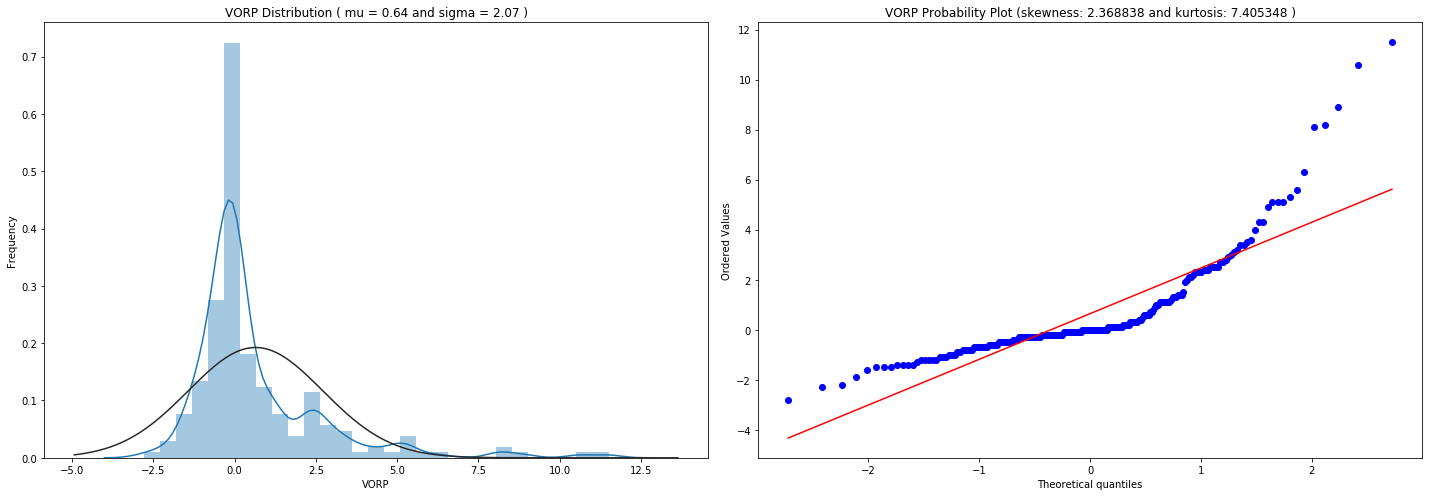

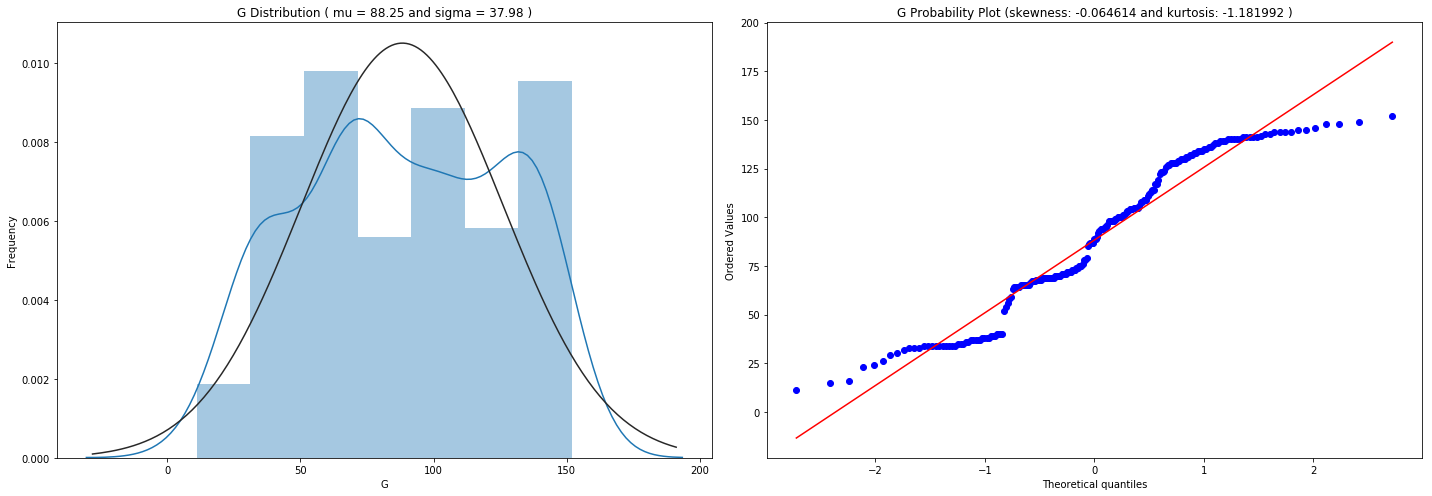

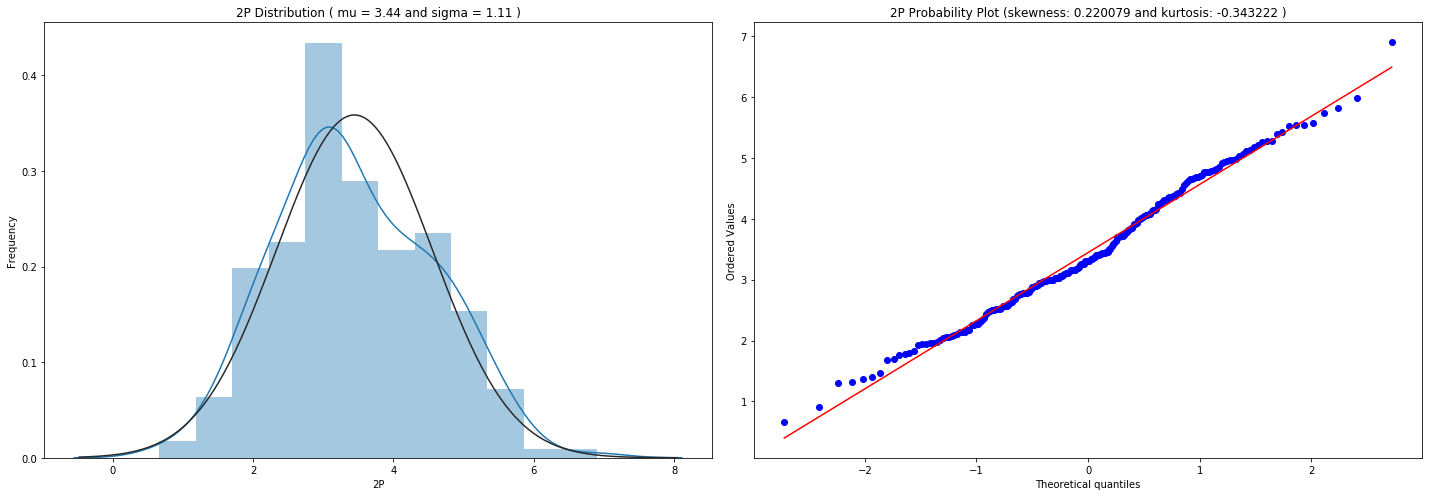

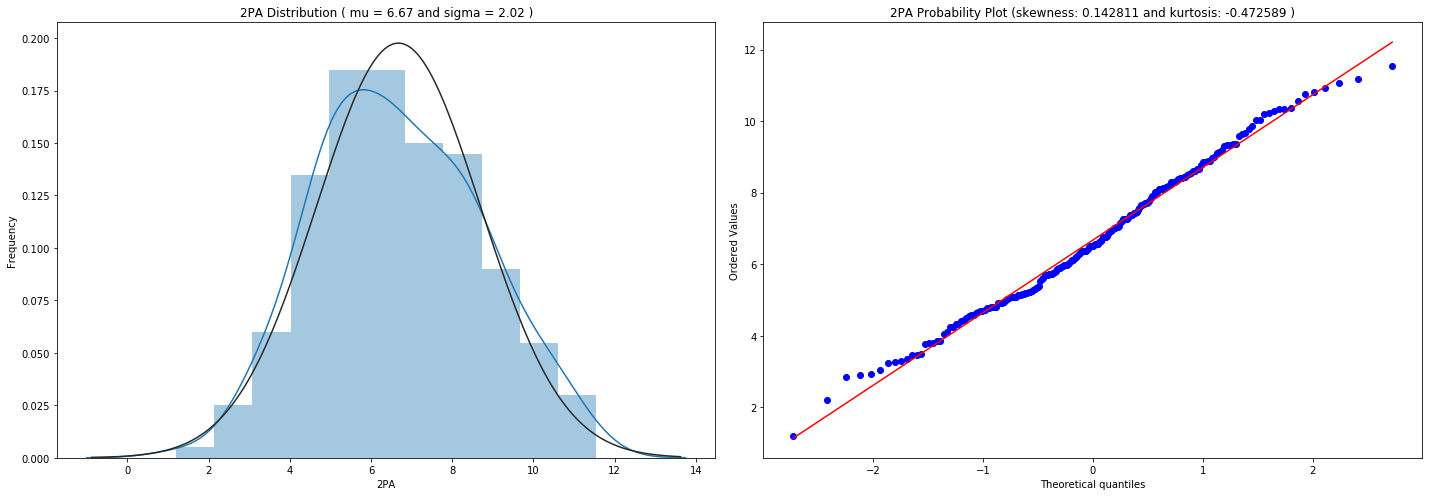

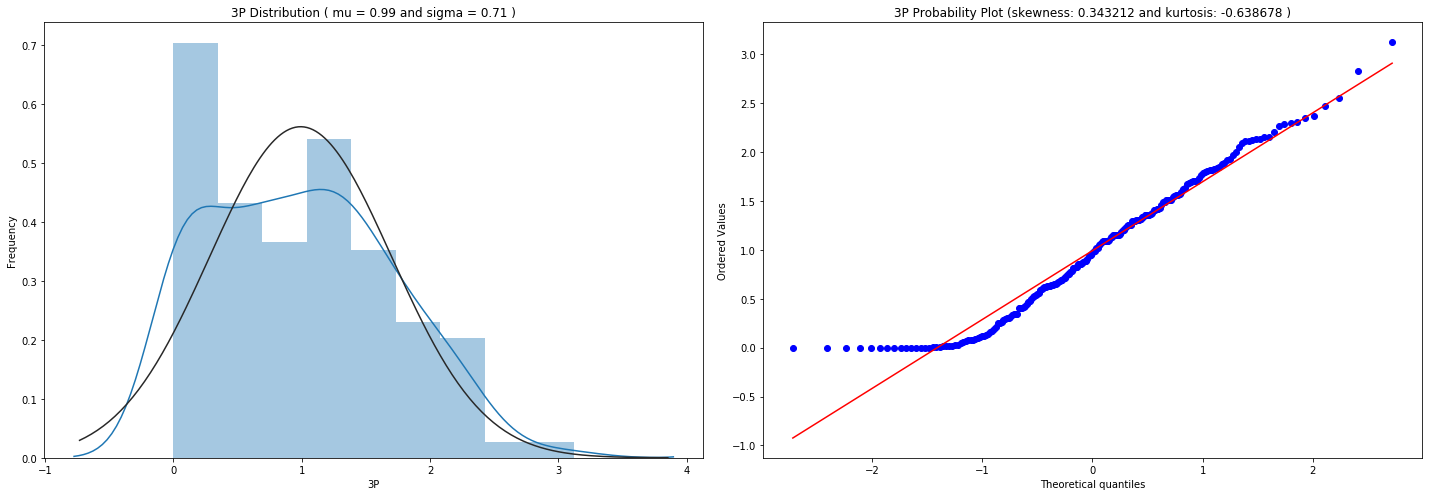

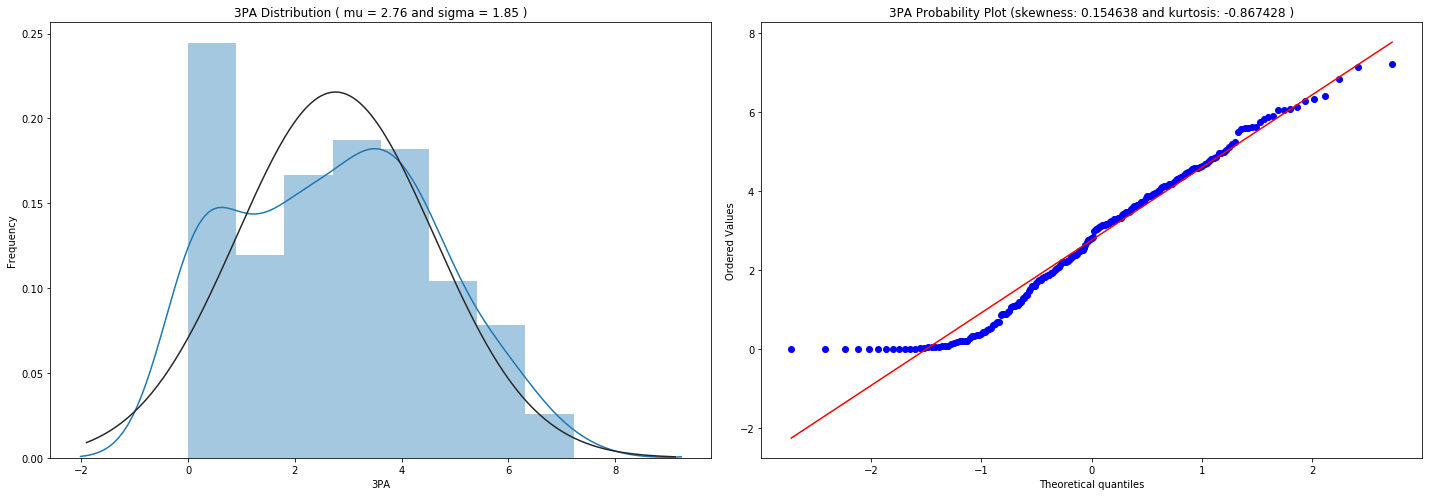

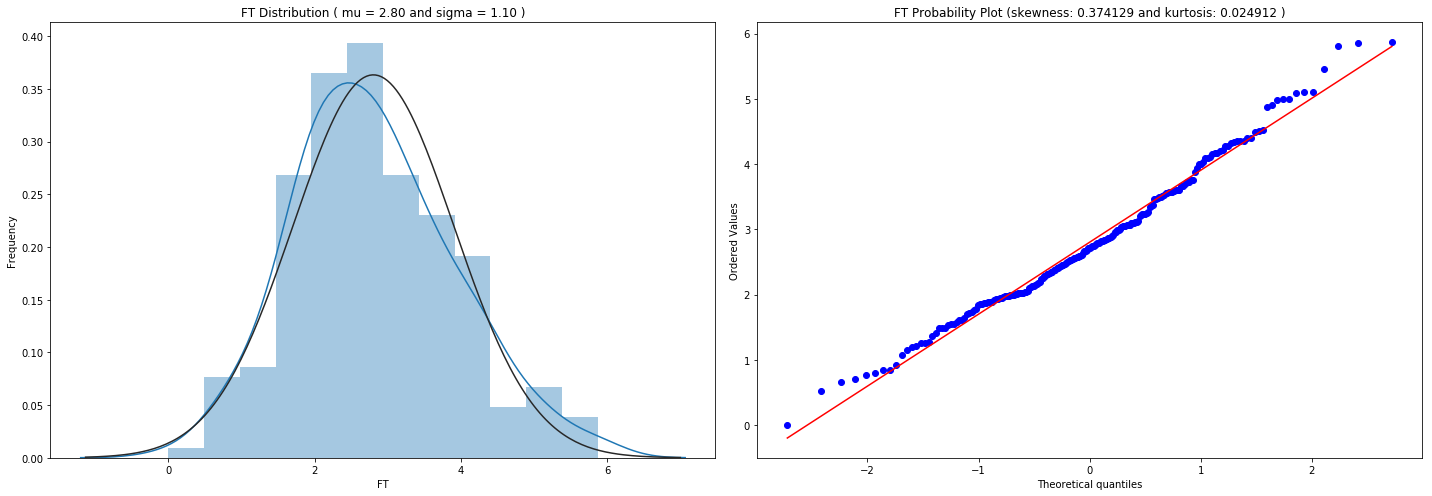

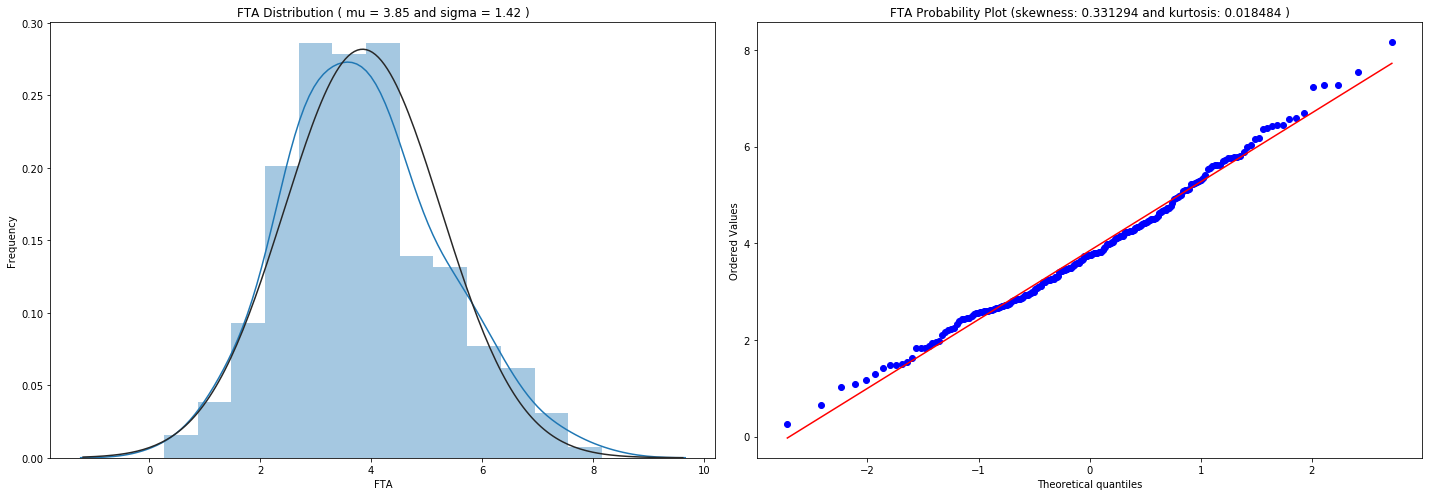

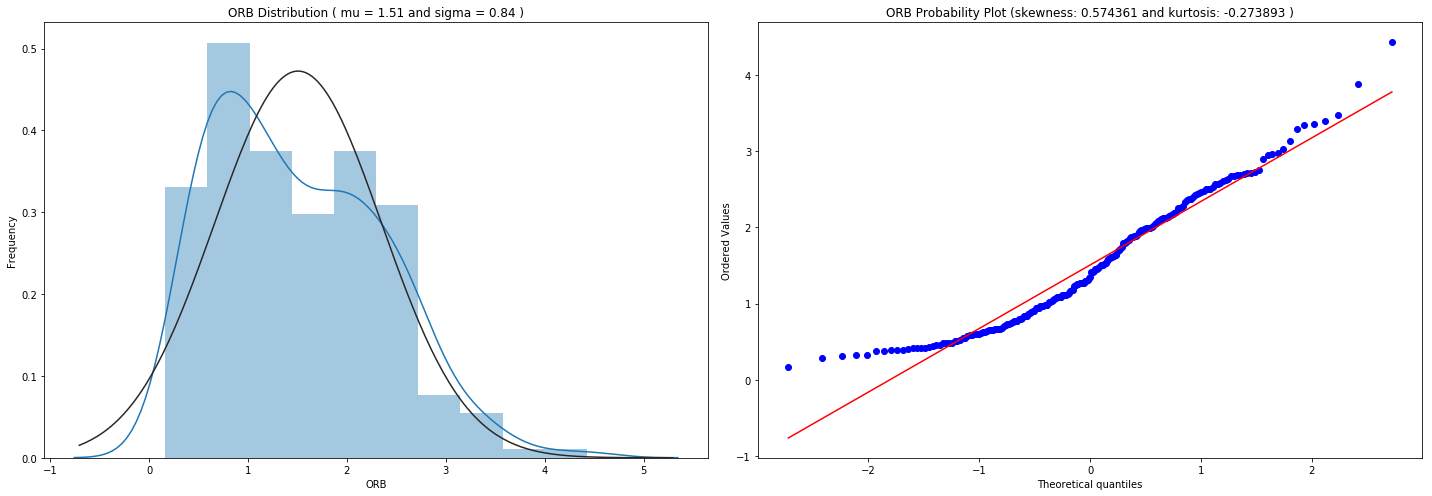

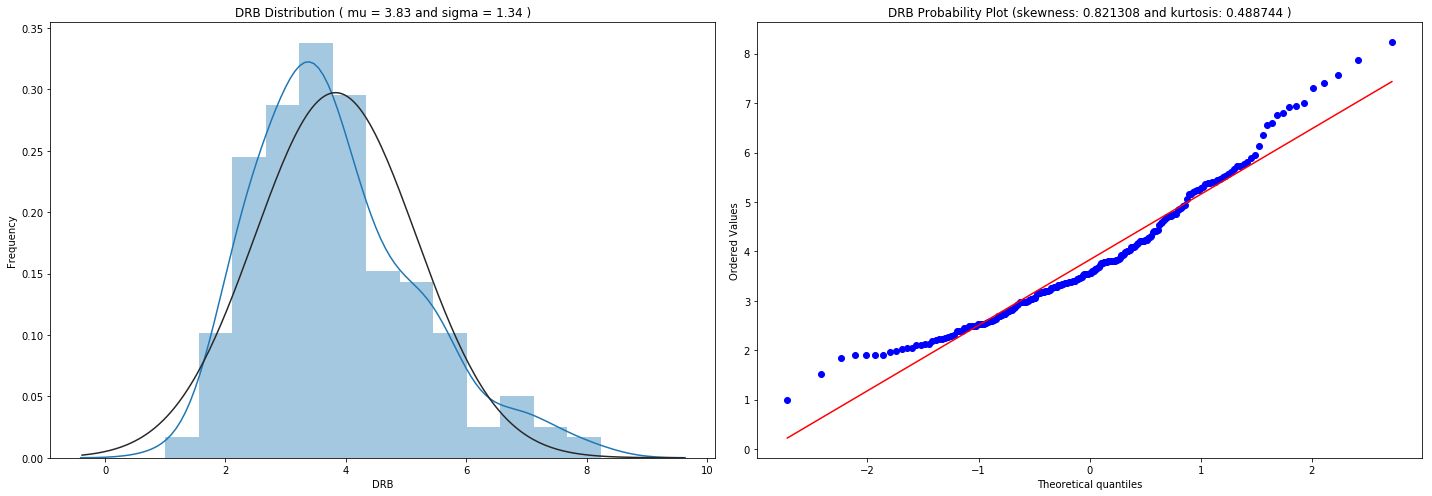

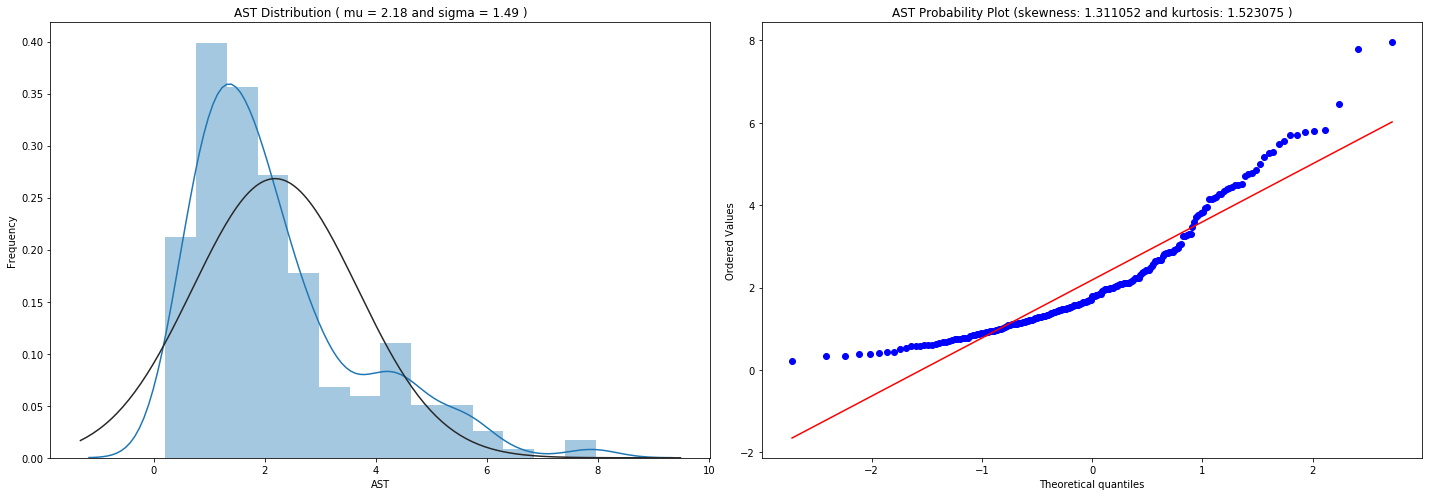

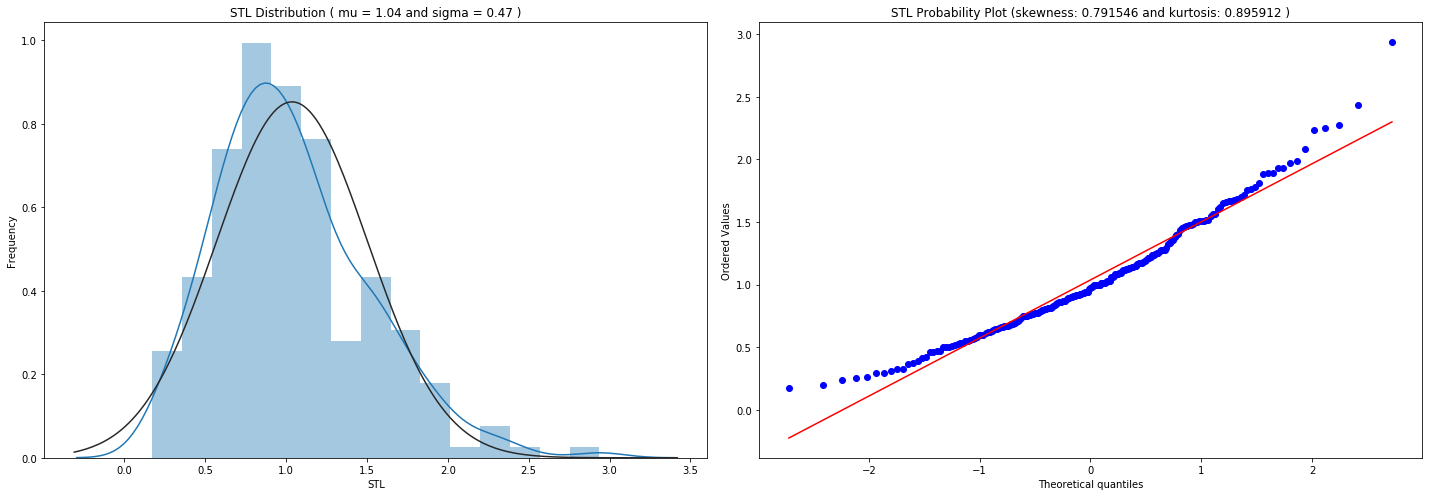

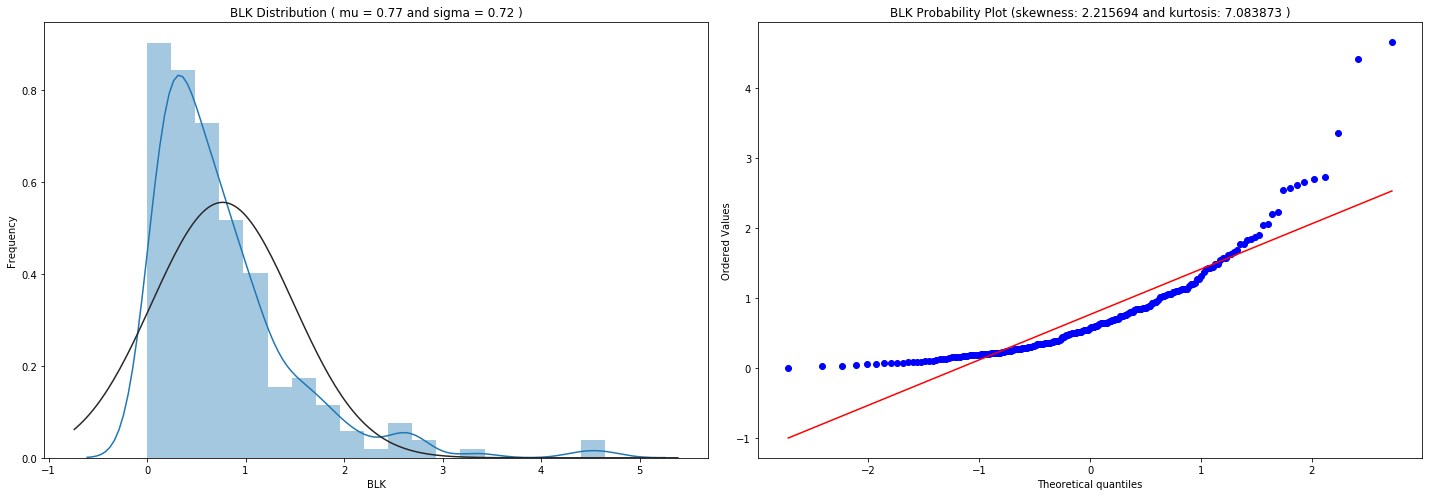

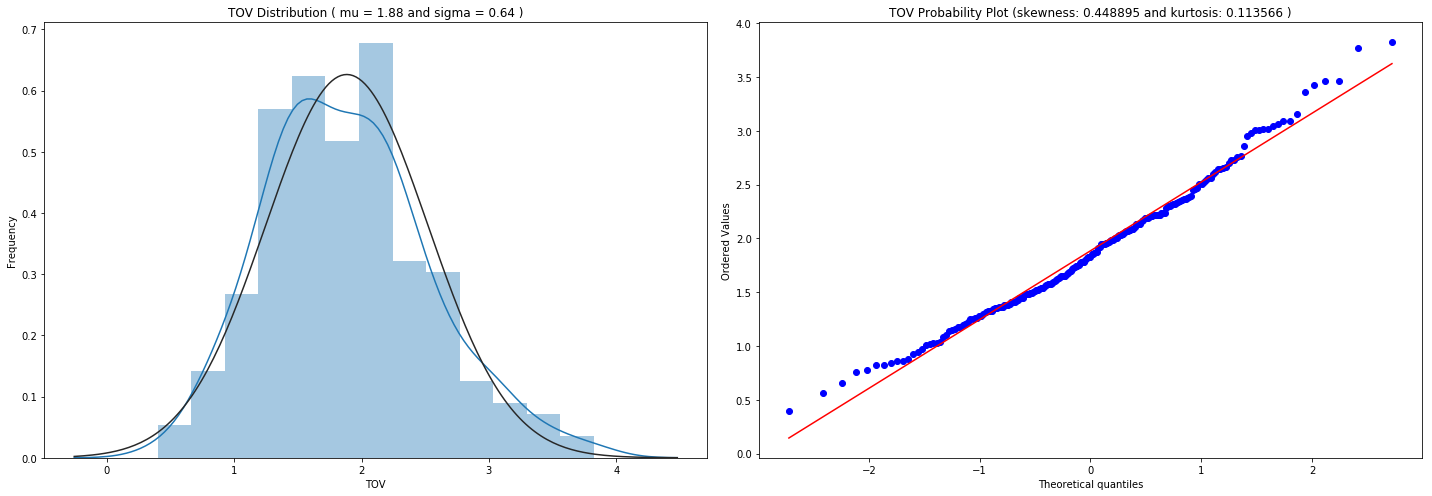

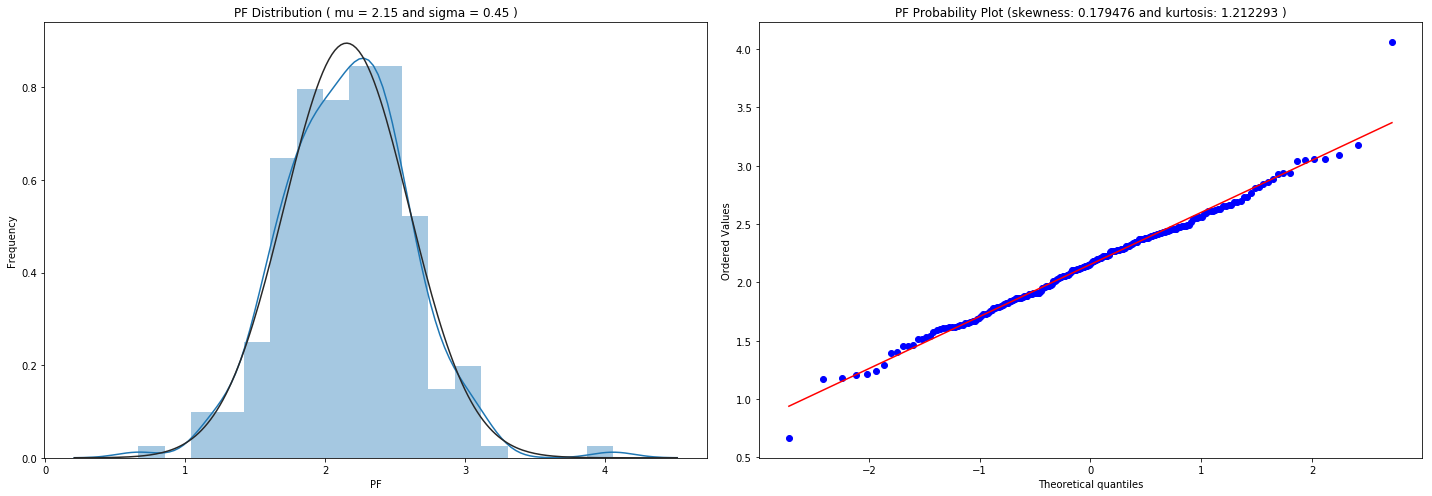

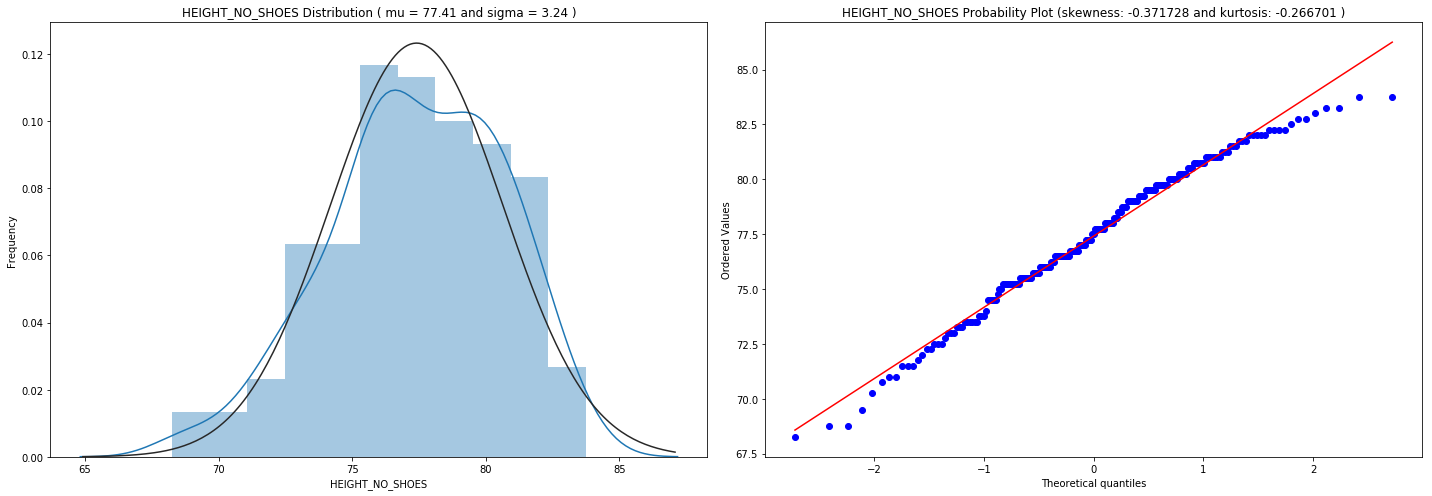

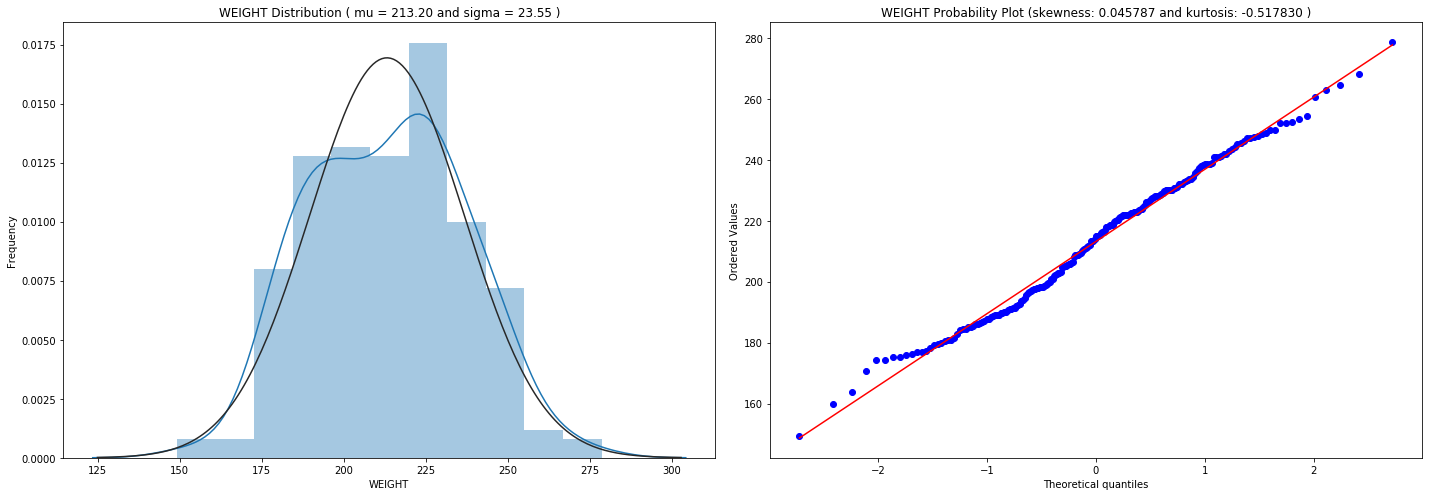

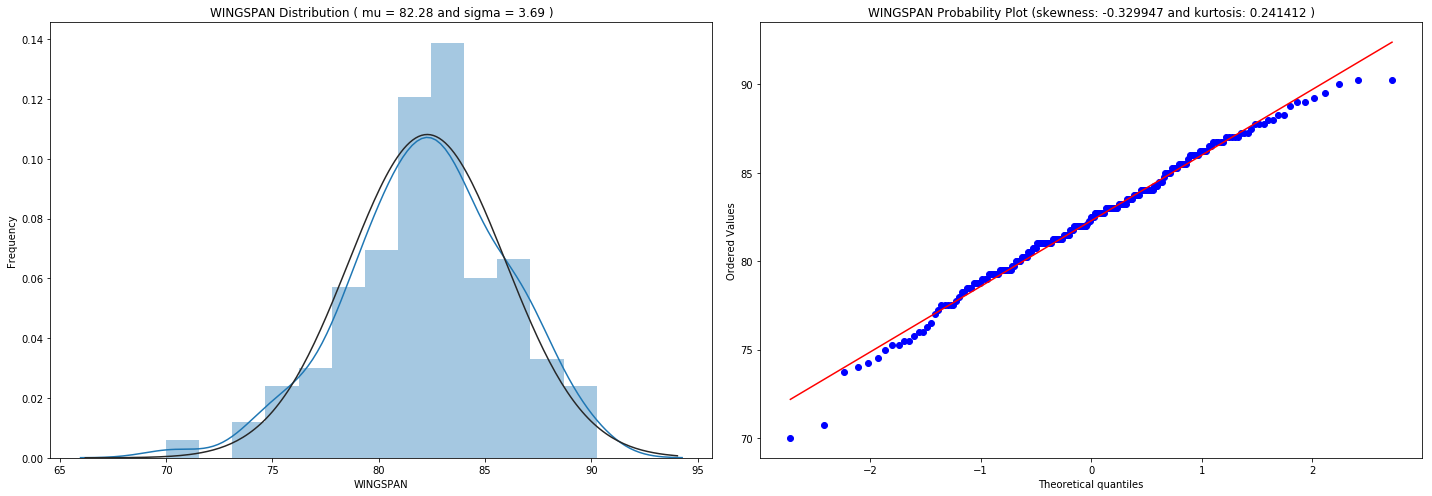

In [48]:
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox
import seaborn as sns

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

for col in col_vorp_us.columns:
    QQ_plot(col_vorp_us[col], col)

In [49]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(col_vorp_us.iloc[:, 1:], col_vorp_us.iloc[:, 0], random_state = 2019)

### 2.2.1 Lasso and Ridge

In [50]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Lasso 
from sklearn.linear_model import Lasso # Lasso Regression class

lasso = Lasso(alpha = 10)   # Lasso 
                           # alpha : constant that multiplies the L1 term. 
                           # Defaults to 1.0. alpha = 0 is equivalent to an ordinary least square, 
                           # solved by the LinearRegression object.
np.random.seed(2019)
lasso.fit(X_train, y_train) # Fit model to data
y_train_pred = lasso.predict(X_train) # Apply model to train data
y_test_pred = lasso.predict(X_test)   # Apply model to test data
print(lasso.coef_)

print('MSE train: %.3f, test: %.3f' % ( # MSE
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred))) # MSE Test Set
print('MAE train: %.3f, test: %.3f' % ( # MAE
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred))) # MAE Test Set

[ 0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.]
MSE train: 3.634, test: 6.278
MAE train: 1.300, test: 1.638


In [51]:
# attributes
np.stack((X_train.columns.values, lasso.coef_), axis = -1)

array([['G', 0.0],
       ['2P', 0.0],
       ['2PA', -0.0],
       ['3P', -0.0],
       ['3PA', -0.0],
       ['FT', 0.0],
       ['FTA', 0.0],
       ['ORB', 0.0],
       ['DRB', 0.0],
       ['AST', 0.0],
       ['STL', 0.0],
       ['BLK', 0.0],
       ['TOV', -0.0],
       ['PF', 0.0],
       ['HEIGHT_NO_SHOES', 0.0],
       ['WEIGHT', 0.0],
       ['WINGSPAN', 0.0]], dtype=object)

In [52]:
# Grid Search

from sklearn.model_selection import GridSearchCV #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

gs_ls = GridSearchCV(estimator = Lasso(),
                  param_grid = [{'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}],
                  scoring = 'neg_mean_squared_error',
                  cv = 5)
#print(len(y))
np.random.seed(2019)
gs_ls = gs_ls.fit(X_train, y_train)    

print(gs_ls.best_score_)
print(gs_ls.best_params_)
print(gs_ls.best_estimator_)

-3.655982168663464
{'alpha': 10}
Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


C:\Users\jczsh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [53]:
# Ridge

from sklearn.linear_model import Ridge # Ridge Regression class

ridge = Ridge(alpha = 10) # Regularization strength; must be a positive float. 
                         # Larger values specify stronger regularization. 
                         # Alpha corresponds to C^-1 in other linear models such as LogisticRegression

np.random.seed(2019)
ridge.fit(X_train, y_train) # Fit Model
y_train_pred = ridge.predict(X_train) # Apply model to train data
y_test_pred = ridge.predict(X_test)  # Apply model to test data
print(ridge.coef_) # Display coefficients

print('MSE train: %.3f, test: %.3f' % ( #MSE 
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred))) #MSE Test Set
print('MAE train: %.3f, test: %.3f' % ( #MAE
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred))) #MAE Test Set

[ 0.00356947  0.42068679 -0.51569554 -0.05678683  0.02796897  0.30550236
  0.0941409   0.27268699  0.25505875  0.26749454  0.61696786  0.26117269
 -0.41203916  0.27037687  0.01972317  0.01443887 -0.07875442]
MSE train: 2.844, test: 5.490
MAE train: 1.102, test: 1.579


In [54]:
# Grid Search

from sklearn.model_selection import GridSearchCV #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

gs_rg = GridSearchCV(estimator = Ridge(),
                  param_grid = [{'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}],
                  scoring = 'neg_mean_squared_error',
                  cv = 5)
#print(len(y))
np.random.seed(2019)
gs_rg = gs_rg.fit(X_train, y_train)    

print(gs_rg.best_score_)
print(gs_rg.best_params_)
print(gs_rg.best_estimator_)

-3.646829973259374
{'alpha': 10}
Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


C:\Users\jczsh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Lasso is better.

In [55]:
# Log Transformation to make attributes more resemble normal distribution

X_train_log = X_train.apply(lambda x: np.log(x + 1))
X_test_log = X_test.apply(lambda x: np.log(x + 1))

In [56]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Lasso 
from sklearn.linear_model import Lasso # Lasso Regression class

lasso = Lasso(alpha = 10)   # Lasso 
                             # alpha : constant that multiplies the L1 term. 
                             # Defaults to 1.0. alpha = 0 is equivalent to an ordinary least square, 
                             # solved by the LinearRegression object.

np.random.seed(2019)
lasso.fit(X_train_log, y_train) # Fit model to data
y_train_pred = lasso.predict(X_train_log) # Apply model to train data
y_test_pred = lasso.predict(X_test_log)   # Apply model to test data
print(lasso.coef_)

print('MSE train: %.3f, test: %.3f' % ( # MSE
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred))) # MSE Test Set
print('MAE train: %.3f, test: %.3f' % ( # MAE
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred))) # MAE Test Set

[-0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
MSE train: 3.634, test: 6.278
MAE train: 1.300, test: 1.638


In [58]:
# attributes
np.stack((X_train_log.columns.values, lasso.coef_), axis = -1)

array([['G', -0.0],
       ['2P', 0.0],
       ['2PA', 0.0],
       ['3P', -0.0],
       ['3PA', -0.0],
       ['FT', 0.0],
       ['FTA', 0.0],
       ['ORB', 0.0],
       ['DRB', 0.0],
       ['AST', 0.0],
       ['STL', 0.0],
       ['BLK', 0.0],
       ['TOV', 0.0],
       ['PF', 0.0],
       ['HEIGHT_NO_SHOES', 0.0],
       ['WEIGHT', 0.0],
       ['WINGSPAN', 0.0]], dtype=object)

### 2.2.2 KNN

In [57]:
# firstly log transformation and then standardize the variables

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train_log)
X_train_std = sc.transform(X_train_log)
X_test_std = sc.transform(X_test_log)

In [59]:
from sklearn import neighbors, datasets


gs_knn = GridSearchCV(estimator=neighbors.KNeighborsRegressor(p=2, 
                           metric='minkowski'),
                  param_grid=[{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
                               'weights':['uniform', 'distance']}],
                  scoring='neg_mean_squared_error',
                  cv=5,
                  n_jobs=4)

np.random.seed(2019)
gs_knn = gs_knn.fit(X_train_std, y_train)          
print(gs_knn.best_score_)
print(gs_knn.best_params_)
print(gs_knn.best_estimator_)

-3.367816631726066
{'n_neighbors': 15, 'weights': 'uniform'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='uniform')


C:\Users\jczsh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [60]:
# KNN

knn = neighbors.KNeighborsRegressor(n_neighbors = gs_knn.best_params_['n_neighbors'], 
                                    weights = gs_knn.best_params_['weights']) #Regression based on k-nearest neighbors.
np.random.seed(2019)
knn = knn.fit(X_train_std, y_train)
y_train_pred = knn.predict(X_train_std) # Apply model to train data
y_test_pred = knn.predict(X_test_std)  # Apply model to test data

print('MSE train: %.3f, test: %.3f' % ( # MSE 
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred))) #MSE Test Set
print('MAE train: %.3f, test: %.3f' % ( # MAE
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred))) #MAE Test Set

MSE train: 3.035, test: 5.925
MAE train: 1.162, test: 1.649


### 2.2.3 Decision Trees - Random Forest (Feature Selection)
can take into consideration categorical variables like 'position'& 'league'.

In [61]:
col_vorp_us.shape

(213, 18)

In [62]:
from sklearn.tree import DecisionTreeRegressor #Documentation available here http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Find the max_depth that minimizes MSE
parameters = {'max_depth': range(3, 50, 1)} # range of parameters for the depth of the tree
gs_dt = GridSearchCV(DecisionTreeRegressor(), parameters, cv = 5, n_jobs=4) #GridSearchCV
np.random.seed(2019)
gs_dt.fit(X_train_log, y_train) # Fit model
tree_model = gs_dt.best_estimator_ # best performance
print (gs_dt.best_score_, gs_dt.best_params_) #parameters that gave the best performance

-0.4835180373683778 {'max_depth': 4}


C:\Users\jczsh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [63]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

tree = DecisionTreeRegressor(max_depth = gs_dt.best_params_['max_depth'])
np.random.seed(2019)
tree.fit(X_train_log, y_train)

y_train_pred = tree.predict(X_train_log) # Apply model to train data
y_test_pred = tree.predict(X_test_log)  # Apply model to test data

print('MSE train: %.3f, test: %.3f' % ( # MSE 
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred))) # MSE Test Set
print('MAE train: %.3f, test: %.3f' % ( # MAE
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred))) # MAE Test Set

MSE train: 2.008, test: 8.025
MAE train: 0.960, test: 1.936


**Random Forest**
</n>

add position and univerisity info

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Find the max_depth that minimizes MSE
parameters = {'max_depth': range(5, 10)
              ,'min_samples_split': range(4, 10)
              # ,'min_samples_leaf': range(2, 5)
              ,'max_features': [0.2, 0.4, 0.6, 0.8]
              ,'n_estimators': range(10, 15)
             } # range of parameters for the depth of the tree

np.random.seed(2019)
gs_rf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4, cv=5) #GridSearchCV

np.random.seed(2019)
gs_rf.fit(X_train_log, y_train) # Fit model
rf_model = gs_rf.best_estimator_ # best performance
print (gs_rf.best_score_, gs_rf.best_params_) #parameters that gave the best performance

0.05930913345672946 {'max_depth': 5, 'max_features': 0.2, 'min_samples_split': 5, 'n_estimators': 13}


C:\Users\jczsh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [66]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(max_depth = gs_rf.best_params_['max_depth']
                           ,n_estimators = gs_rf.best_params_['n_estimators']
                           ,min_samples_split = gs_rf.best_params_['min_samples_split'] 
                           # min_samples_leaf = gs_rf.best_params_['min_samples_leaf'],
                           ,max_features = gs_rf.best_params_['max_features']
                                    )

np.random.seed(2019)
randomForest.fit(X_train_log, y_train)

y_train_pred = randomForest.predict(X_train_log) # Apply model to train data
y_test_pred = randomForest.predict(X_test_log)  # Apply model to test data

print('MSE train: %.3f, test: %.3f' % ( # MSE 
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred))) # MSE Test Set
print('MAE train: %.3f, test: %.3f' % ( # MAE
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred))) # MAE Test Set

MSE train: 1.506, test: 5.397
MAE train: 0.842, test: 1.540


In [67]:
importances = randomForest.feature_importances_
std = np.std([randomForest.feature_importances_ for tree in randomForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train_log.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train_log.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. STL (0.130200)
2. DRB (0.108834)
3. G (0.106227)
4. 3P (0.088911)
5. HEIGHT_NO_SHOES (0.088911)
6. FT (0.067279)
7. ORB (0.054995)
8. 2P (0.052012)
9. WEIGHT (0.051871)
10. PF (0.046577)
11. 3PA (0.042623)
12. WINGSPAN (0.038399)
13. 2PA (0.034206)
14. TOV (0.029331)
15. FTA (0.025069)
16. BLK (0.018999)
17. AST (0.015556)


In [68]:
for f in range(X_train_log.shape[1]):
    t = zip((X_train_log.columns[indices[f]], importances[indices[f]]))

In [69]:
pd.DataFrame({
 'Name': np.array(X_train_log.columns), 
             'Importance': importances   
}).sort_values('Importance', ascending = False).to_csv('Importance.csv', index = False)

In [70]:
np.corrcoef(y_test, y_test_pred) # 0.37 correlation

array([[1.       , 0.3663592],
       [0.3663592, 1.       ]])

In [71]:
pd.DataFrame(np.stack((y_test, y_test_pred), axis = -1)).sort_values([1], ascending = False)

,0,1
30,3.4,2.703758
34,0.0,2.624528
21,11.5,2.123042
36,-0.8,1.709152
24,1.3,1.474282
51,-0.3,1.428695
7,-0.8,1.390595
9,1.5,1.383513
17,2.4,1.315112
6,3.2,1.313707


## 2.3 Predictions & Evaluation
Results:
predictions, can the model recognize the talents that were not recognized and find 'busts' that are overvalued? (2018 Draft)

### 2.3.1 Overall - 2018

In [72]:
col_vorp_us = col_vorp[(col_vorp.Player.isin(drafts.loc[drafts.Country == 'USA', 'Player']))]

col_vorp_us = col_vorp_us.drop_duplicates(subset = 'Player')

train = col_vorp_us[col_vorp_us.Year <= 2017]
test = col_vorp_us[col_vorp_us.Year == 2018]

train.drop(['Year', 'Player'], axis = 1, inplace = True)
test.drop(['Year', 'Player'], axis = 1, inplace = True)

C:\Users\jczsh\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [73]:
X_train = train.iloc[:,1:]
y_train = train.iloc[:, 0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:, 0]

In [74]:
X_train_log = X_train.apply(lambda x: np.log(x+1))
X_test_log = X_test.apply(lambda x: np.log(x+1))

In [75]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(max_depth = gs_rf.best_params_['max_depth']
                           ,n_estimators = gs_rf.best_params_['n_estimators']
                           ,min_samples_split = gs_rf.best_params_['min_samples_split'] 
                           # min_samples_leaf = gs_rf.best_params_['min_samples_leaf'],
                           ,max_features = gs_rf.best_params_['max_features']
                                    )

np.random.seed(2019)
randomForest.fit(X_train_log, y_train)

y_train_pred = randomForest.predict(X_train_log) # Apply model to train data
y_test_pred = randomForest.predict(X_test_log)  # Apply model to test data

print('MSE train: %.3f, test: %.3f' % ( # MSE 
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred))) # MSE Test Set
print('MAE train: %.3f, test: %.3f' % ( # MAE
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred))) # MAE Test Set

MSE train: 2.168, test: 1.072
MAE train: 0.999, test: 0.778


In [76]:
np.corrcoef(y_test, y_test_pred) # 0.16 correlation

array([[1.        , 0.23788042],
       [0.23788042, 1.        ]])

In [77]:
col_vorp_us.loc[col_vorp_us.Year == 2018, 'Player']

276      Jaren Jackson
277      Landry Shamet
279         Trae Young
280      Miles Bridges
281      Jalen Brunson
282      Mohamed Bamba
283      Kevin Huerter
284     Omari Spellman
285        Bruce Brown
286     Hamidou Diallo
287        Josh Okogie
288      Aaron Holiday
290         Troy Brown
291       Shake Milton
293    Jerome Robinson
294       Khyri Thomas
296        George King
297      Grayson Allen
299     Melvin Frazier
300      Alize Johnson
302        Jacob Evans
303      Lonnie Walker
304      Chimezie Metu
305       Jevon Carter
306      Collin Sexton
307         Kevin Knox
Name: Player, dtype: object

In [80]:
result = pd.DataFrame(np.stack((col_vorp_us.loc[col_vorp_us.Year == 2018, 'Player'], y_test, y_test_pred), axis = -1)).sort_values([1], ascending = False)
result.columns = ['Player', 'VORP S18-19', 'Projected VORP']
result = pd.merge(result, drafts[['Player', 'Rank', 'Position']], on = 'Player')
result['Projected Rank'] = result['Projected VORP'].rank(ascending = False)

result.sort_values('Projected Rank').to_csv('result.csv', index = False)